## Manifold testing for continuous case ambiguity

This notebook compare different types of manifold method like simple hypercube and convex hull to compare the influence on ambiguity estimation. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))


In [2]:
# Function to generate two-dimensional data for multiple classes
def generate_two_dimensional_data(num_samples_per_class):
    """Generate two dimentional data set for multiple classes"""
    np.random.seed(0)  

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]] 
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [-2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]] 
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['class'] = labels

    return df

In [3]:
# Function to plot hypercubes and samples
def plot_hypercube_and_samples(df, feature_x, feature_y, class_column):
    classes = df[class_column].unique()
    plt.figure(figsize=(10, 8))
    
    for cls in classes:
        subset = df[df[class_column] == cls]
        min_x, max_x = subset[feature_x].min(), subset[feature_x].max()
        min_y, max_y = subset[feature_y].min(), subset[feature_y].max()
        
        # Plotting samples
        plt.scatter(subset[feature_x], subset[feature_y], label=f'Class {cls}')
        
        # Plotting hypercube boundaries
        plt.plot([min_x, max_x], [min_y, min_y], 'k--')
        plt.plot([min_x, max_x], [max_y, max_y], 'k--')
        plt.plot([min_x, min_x], [min_y, max_y], 'k--')
        plt.plot([max_x, max_x], [min_y, max_y], 'k--')
    
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title('Hypercubes and Samples Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

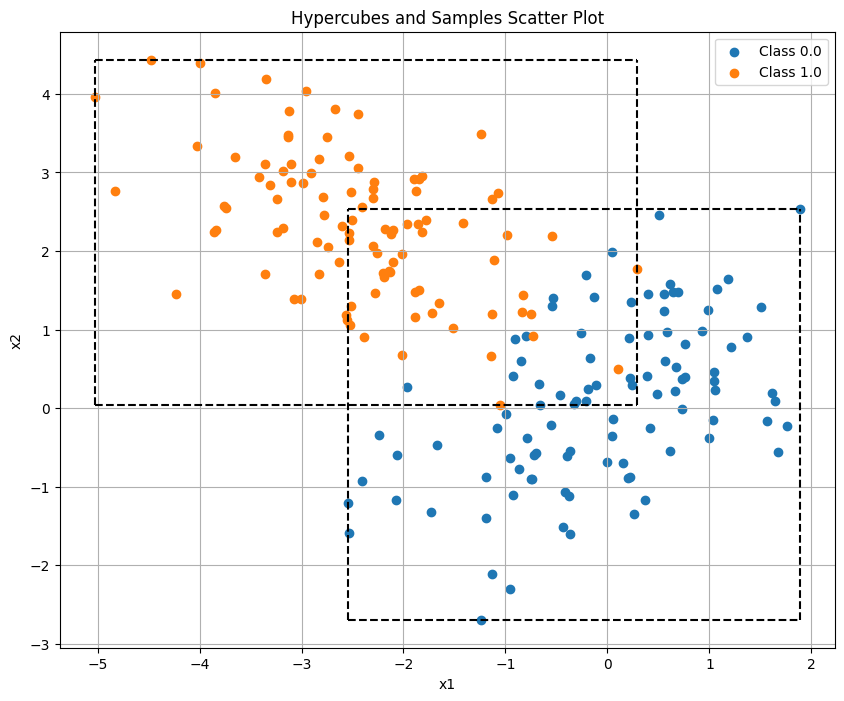

In [4]:
# generate a dataframe with 100 samples per class
df = generate_two_dimensional_data(100)
plot_hypercube_and_samples(df, 'x1', 'x2', 'class')

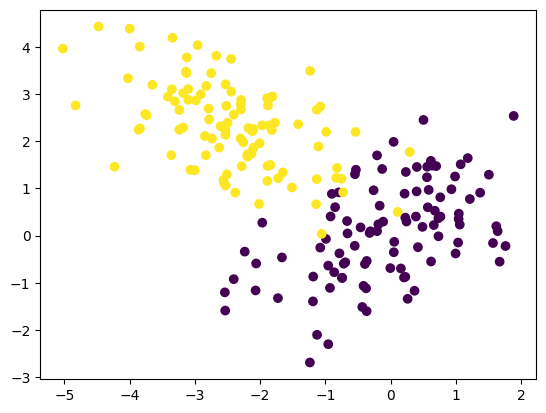

In [5]:
# Simple scatter plot of the generated data
import matplotlib.pyplot as plt
plt.scatter(df['x1'], df['x2'], c=df['class'], cmap="viridis")
plt.show()

In [6]:
# Caculate continuous case ambiguity using recatngular bounding box methods
from continuous import ContinuousAmbiguityError
X = df[['x1', 'x2']].to_numpy()
y = df['class'].to_numpy()
ambiguity_error = ContinuousAmbiguityError(X, y)

ambiguity, overlap_regions, samples_in_overlap = ambiguity_error.calculate_ambiguity_hypercube()
print("Ambiguity: {:.4f}".format(ambiguity))
print("Overlap Regions:\n",overlap_regions[0][0])
print("Overlap region boundaries class 0:\n", overlap_regions[0][1])
print("Overlap region boundaries class 1:\n", overlap_regions[0][2])
print("Number of samples in overlap region:", samples_in_overlap)


Ambiguity: 0.3300
Overlap Regions:
 (0.0, 1.0)
Overlap region boundaries class 0:
 [-2.54168126  0.03537066]
Overlap region boundaries class 1:
 [0.29087077 2.53776333]
Number of samples in overlap region: {'0.0-1.0': {0.0: 24, 1.0: 42}}


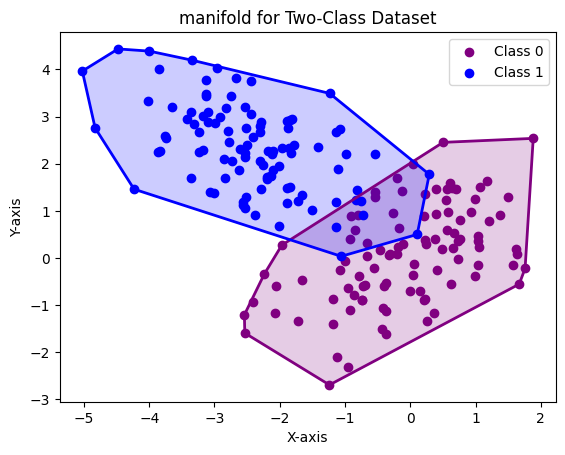

In [7]:
# Testing tighter bounding shape using Convex Hull
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

np.random.seed(0)
class_0 = df[df['class']==0][['x1', 'x2']].values
class_1 = df[df['class']==1][['x1', 'x2']].values

def plot_convex_hull(points, ax, color):
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], color=color, linewidth=2)
        ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.2)

fig, ax = plt.subplots()

ax.scatter(class_0[:, 0], class_0[:, 1], color='purple', label='Class 0')
plot_convex_hull(class_0, ax, color='purple')

ax.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Class 1')
plot_convex_hull(class_1, ax, color='blue')

# Add legend and show plot
ax.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('manifold for Two-Class Dataset')
plt.show()

In [8]:
# ambiguty calculation using convex hull
ambiguity_hull = ambiguity_error.calculate_ambiguity_convex_hull()
print("Ambiguity (Convex Hull): {:.4f}".format(ambiguity_hull))

Ambiguity (Convex Hull): 0.0950


In [9]:
from sklearn.datasets import load_iris
import pandas as pd
# Load the dataset
iris = load_iris()
# Convert to pandas DataFrame
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
y = df['class'].to_numpy()

ambiguity_iris = ambiguity_error.calculate_ambiguity_convex_hull(X, y)
print("Ambiguity (Iris Dataset, Convex Hull): {:.4f}".format(ambiguity_iris))

Ambiguity (Iris Dataset, Convex Hull): 0.0067


In [11]:
# testing the accuracy of 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define feature matrix X and target vector y
X = df[df.columns[:-1]].values  # Use all columns except the last one as features
y = df['class'].values  # Use the 'class' column as the target variable

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to evaluate
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    train_pred = model.predict(X_train)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f"{name} test_Accuracy: {accuracy:.2f}")
    print(f"{name} train_Accuracy: {train_accuracy:.2f}")


Random Forest test_Accuracy: 1.00
Random Forest train_Accuracy: 1.00
SVM test_Accuracy: 1.00
SVM train_Accuracy: 0.97
Logistic Regression test_Accuracy: 1.00
Logistic Regression train_Accuracy: 0.97
Decision Tree test_Accuracy: 1.00
Decision Tree train_Accuracy: 1.00
KNN test_Accuracy: 1.00
KNN train_Accuracy: 0.97


In [12]:
from model import Model

model = Model('rf')
model.data_split(df)
# model.train(df)
# result = model.evaluate()
cross_val = model.cross_validate_with_metrics(cv=2)

/home/shiblu/Workspace/university/FAU_Courses/FAU Summer 2024/Seminar/Codes/src/continuous.py:203: UserWarning: An integral in _mvn.mvnun requires more points than 4000
  error_probability = kde.integrate_box(bounds_min, bounds_max, maxpts=500000)
/home/shiblu/Workspace/university/FAU_Courses/FAU Summer 2024/Seminar/Codes/src/continuous.py:203: UserWarning: An integral in _mvn.mvnun requires more points than 4000
  error_probability = kde.integrate_box(bounds_min, bounds_max, maxpts=500000)


In [13]:
df_results = pd.DataFrame(cross_val)
df_results

,fold,train_ambiguity,train_error,train_accuracy,train_balanced_accuracy,train_theretical_limit,train_theretical_error,test_ambiguity,test_error,test_accuracy,test_balanced_accuracy,test_theretical_limit,test_theretical_error
0,1,0.0,0.0,1.0,1.0,1.0,0.457367,0.0,0.013333,0.986667,0.985507,1.0,0.343104
1,2,0.0,0.0,1.0,1.0,1.0,0.343104,0.0,0.080000,0.920000,0.925926,1.0,0.457367


In [14]:
from model import Model

model = Model('lr')
model.data_split(df)
# model.train(df)
# result = model.evaluate()
cross_val = model.cross_validate_with_metrics(cv=3)

/home/shiblu/Workspace/university/FAU_Courses/FAU Summer 2024/Seminar/Codes/src/continuous.py:203: UserWarning: An integral in _mvn.mvnun requires more points than 4000
  error_probability = kde.integrate_box(bounds_min, bounds_max, maxpts=500000)


In [15]:
df_results = pd.DataFrame(cross_val)
df_results

,fold,train_ambiguity,train_error,train_accuracy,train_balanced_accuracy,train_theretical_limit,train_theretical_error,test_ambiguity,test_error,test_accuracy,test_balanced_accuracy,test_theretical_limit,test_theretical_error
0,1,0.0,0.04,0.96,0.961625,1.00,0.361129,0.0,0.00,1.00,1.000000,1.0,0.375475
1,2,0.0,0.00,1.00,1.000000,1.00,0.339399,0.0,0.08,0.92,0.918954,1.0,0.374449
2,3,0.0,0.03,0.97,0.968414,0.99,0.342404,0.0,0.02,0.98,0.982456,1.0,0.373718
